# Manga Translator

## Introduction

I love reading manga, and I can't wait for the next chapter of my favorite manga to be released. However, the newest chapters are usually in Japanese, and they are translated to English after some time. I want to read the newest chapters as soon as possible, so I decided to build a manga translator that can translate Japanese manga to English.

## Approach

I want to translate the text in the manga images from Japanese to English. I will first need to know where these speech bubbles are on the image. For this I will use `Yolov8` to detect the speech bubbles. Once I have the speech bubbles, I will use `manga-ocr` to extract the text from the speech bubbles. Finally, I will use `deep-translator` to translate the text from Japanese to English.

## Yolov8

`Yolov8` is a state-of-the-art, real-time object detection system [that I've used in the past before](https://github.com/Detopall/parking-lot-prediction). I will use `Yolov8` to detect the speech bubbles in the manga images.

## Manga-ocr

Optical character recognition for Japanese text, with the main focus being Japanese manga. This Python package is built and trained specifically for extracting text from manga images. This makes it perfect for extracting text from the speech bubbles in the manga images.

## Deep-translator

`Deep-translator` is a Python package that uses the Google Translate API to translate text from one language to another. I will use `deep-translator` to translate the text extracted from the manga images from Japanese to English.

## Data Preparation

This [dataset](https://universe.roboflow.com/speechbubbledetection-y9yz3/bubble-detection-gbjon/dataset/2#) contains over 8500 images of manga pages together with their annotations from Roboflow. I will use this dataset to train `Yolov8` to detect the speech bubbles in the manga images. To use this dataset with Yolov8, I will need to convert the annotations to the YOLO format, which is a text file containing the class label and the bounding box coordinates of the object in the image.

This dataset is over 1.7GB in size, so I will need to download it to my local machine. The rest of the code should be run after the dataset has been downloaded and extracted in this directory.

The dataset contains mostly English manga, but that is fine since I am only interested in the speech bubbles.

### Yolov8 format

```
class_index x1, y1, x2, y2, x3, y3, x4, y4
```

Where:
- `class_index` is the index of the class in the class list
- `(x1, y1), (x2, y2), (x3, y3), (x4, y4)` are the coordinates of the bounding box
- The coordinates are normalized to the range [0, 1]
- The coordinates are in the format `(x, y)`, where `x` is the horizontal coordinate and `y` is the vertical coordinate

Since the dataset is taken from Roboflow, the annotations are in the Roboflow format. I don't need to do any data preprocessing for this dataset.

### Example of the images and annotations

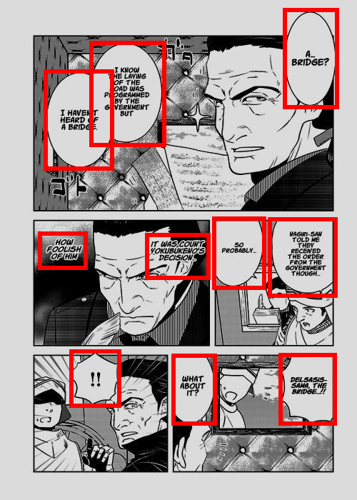

In [184]:
# Refactored code to draw OBB format bounding boxes on an image with coordinate transformation

from IPython.display import display
import random
from PIL import Image, ImageDraw
import os

# Function to draw bounding boxes on an image
def draw_bounding_boxes(image_path, label_path):
    # Load the image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    width, height = image.size

    # Load the labels
    with open(label_path, "r") as f:
        labels = f.readlines()

    # Draw the bounding boxes
    for label in labels:
        label = label.strip().split(" ")
        class_index = label[0]
        coordinates = list(map(float, label[1:]))

        # Extract the normalized coordinates and transform them to pixel coordinates
        x1, y1 = coordinates[0] * width, coordinates[1] * height
        x2, y2 = coordinates[2] * width, coordinates[3] * height
        x3, y3 = coordinates[4] * width, coordinates[5] * height
        x4, y4 = coordinates[6] * width, coordinates[7] * height

        # Draw the polygon (bounding box)
        draw.polygon([(x1, y1), (x2, y2), (x3, y3), (x4, y4)], outline="red", width=6)

    # Resize for better display
    image.thumbnail((500, 500))
    return image

# Select a random image and corresponding label file
random_image_path = random.choice(os.listdir("data/train/images"))
random_label_path = random_image_path.replace("images", "labels").replace(".jpg", ".txt")

# Full paths
image_path = os.path.join("data/train/images", random_image_path)
label_path = os.path.join("data/train/labels", random_label_path)

# Draw and display the image with bounding boxes
image_with_boxes = draw_bounding_boxes(image_path, label_path)
display(image_with_boxes)

## Train the model

In [ ]:
# Fine tune the model on the dataset
from ultralytics import YOLO

model = YOLO("yolov8s.pt")

model.train(data="./data/data.yaml", epochs=5)

In [5]:
# load specific model, trained on GPU on Google Colab
import os
from ultralytics import YOLO

best_model_path = "./runs/detect/train5"

model = YOLO(os.path.join(best_model_path, "weights/best.pt"))

## Test the model

c:\Users\denis\.virtualenvs\manga-translator-P3KeupUf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


image 1/1 c:\Users\denis\Desktop\projects\data-science\manga-translator\model_creation\data\test\images\-1269-_jpg.rf.411983b7603b2baf5b74acd242999e75.jpg: 640x480 7 text_bubbles, 453.5ms
Speed: 6.2ms preprocess, 453.5ms inference, 1268.7ms postprocess per image at shape (1, 3, 640, 480)
Object: text_bubble
Coordinates: [92, 185, 158, 276]
Probability: 0.9149
Object: text_bubble
Coordinates: [286, 272, 353, 379]
Probability: 0.9088
Object: text_bubble
Coordinates: [80, 597, 145, 688]
Probability: 0.9015
Object: text_bubble
Coordinates: [249, 343, 302, 428]
Probability: 0.8964
Object: text_bubble
Coordinates: [168, 14, 237, 113]
Probability: 0.8953
Object: text_bubble
Coordinates: [140, 116, 200, 210]
Probability: 0.8913
Object: text_bubble
Coordinates: [373, 0, 444, 85]
Probability: 0.8894


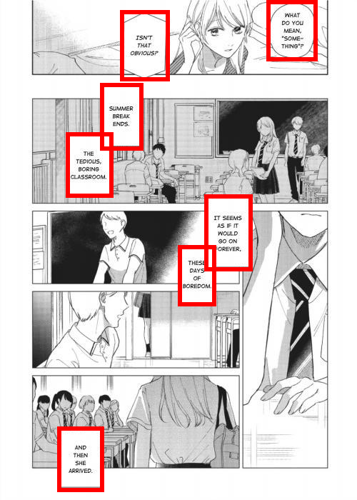

In [7]:
import random

random_image_path = random.choice(os.listdir("data/test/images"))
image_path = f"data/test/images/{random_image_path}"
image = Image.open(image_path)

# Perform inference
result = model.predict(image_path)[0]

# Draw the bounding boxes around the text
draw = ImageDraw.Draw(image)
for box in result.boxes:
	label = result.names[box.cls[0].item()]
	coords = [round(x) for x in box.xyxy[0].tolist()]
	prob = round(box.conf[0].item(), 4)
	print("Object: {}\nCoordinates: {}\nProbability: {}".format(label, coords, prob))
	draw.rectangle(coords, outline="red", width=6)

image.thumbnail((500, 500))
display(image)

## Model Evaluations

confusion_matrix


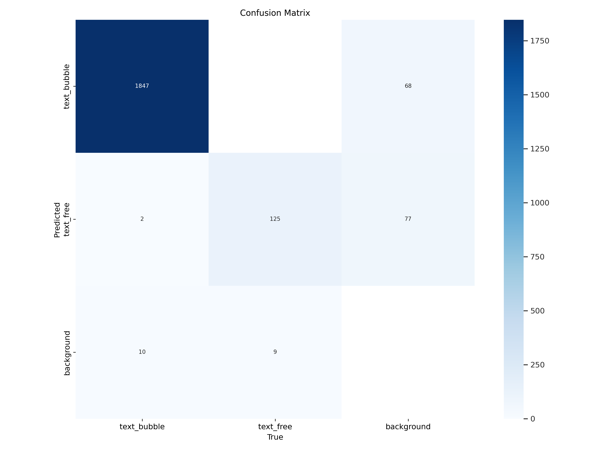

confusion_matrix_normalized


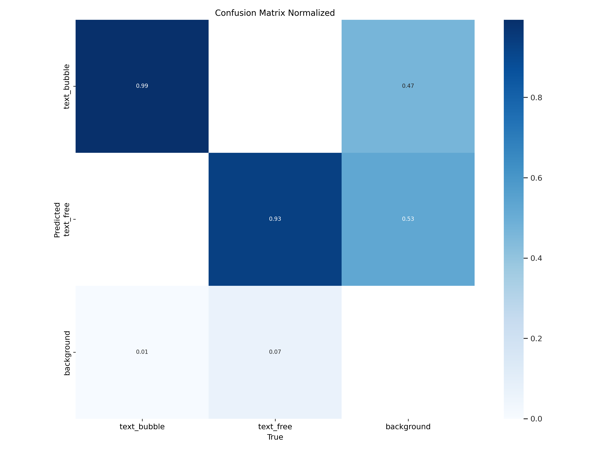

f1_curve


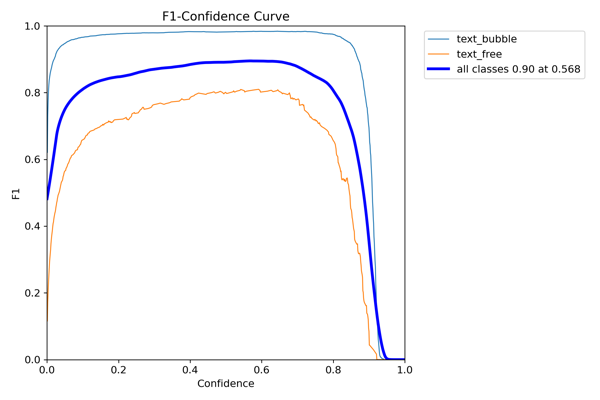

p_curve


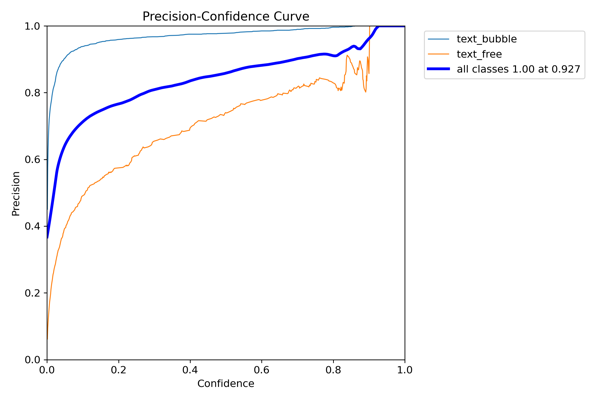

r_curve


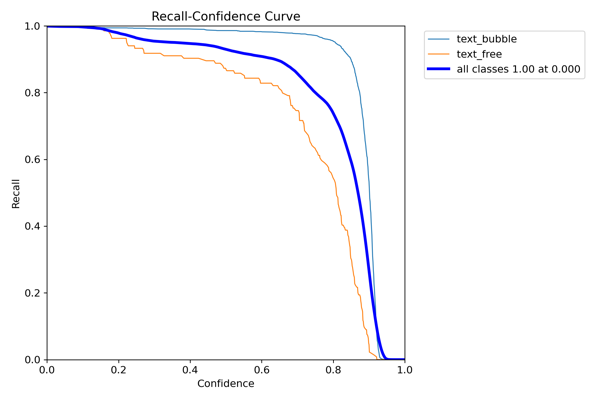

results


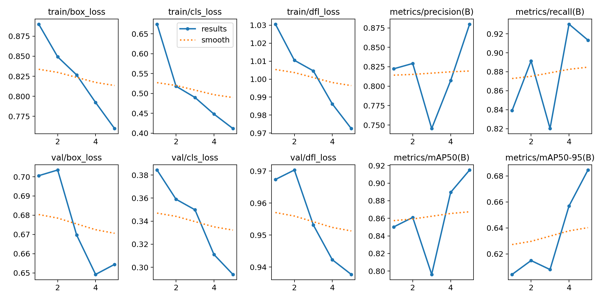

In [8]:
images_dict = {
	"confusion_matrix": f"{best_model_path}/confusion_matrix.png",
	"confusion_matrix_normalized": f"{best_model_path}/confusion_matrix_normalized.png",
	"f1_curve": f"{best_model_path}/F1_curve.png",
	"p_curve": f"{best_model_path}/P_curve.png",
	"r_curve": f"{best_model_path}/R_curve.png",
	"results": f"{best_model_path}/results.png"
}


for title, path in images_dict.items():
	image = Image.open(path)
	image.thumbnail((600, 600))
	print(title)
	display(image)

## Manga OCR

This section will contain the code for extracting text from the speech bubbles in the manga images using `manga-ocr`. But firstly we have to use the previously trained model to detect the speech bubbles in the manga images and then create individual images of the speech bubbles.

In [36]:
import uuid
from PIL import Image
import os

# Get Japanese manga image
image_path = "./011.png"

image = Image.open(image_path)
bounding_box_images_path = "./bounding_box_images"

# Create the directory if it doesn't exist
if not os.path.exists(bounding_box_images_path):
	os.makedirs(bounding_box_images_path)

# Clear the directory
for file in os.listdir(bounding_box_images_path):
	os.remove(os.path.join(bounding_box_images_path, file))

# Perform inference
result = model.predict(image_path)[0]

for box in result.boxes:
	label = result.names[box.cls[0].item()]
	coords = [round(x) for x in box.xyxy[0].tolist()]
	prob = round(box.conf[0].item(), 4)
	print("Object: {}\nCoordinates: {}\nProbability: {}".format(label, coords, prob))
	cropped_image = image.crop(coords)

	# save each image under a unique name
	cropped_image.save(f"{bounding_box_images_path}/{uuid.uuid4()}.png")


image 1/1 c:\Users\denis\Desktop\projects\data-science\manga-translator\model_creation\011.png: 640x480 8 text_bubbles, 353.9ms
Speed: 3.7ms preprocess, 353.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)
Object: text_bubble
Coordinates: [608, 88, 748, 308]
Probability: 0.9075
Object: text_bubble
Coordinates: [70, 390, 250, 594]
Probability: 0.9057
Object: text_bubble
Coordinates: [86, 121, 225, 345]
Probability: 0.8989
Object: text_bubble
Coordinates: [683, 672, 827, 906]
Probability: 0.897
Object: text_bubble
Coordinates: [325, 657, 504, 917]
Probability: 0.8882
Object: text_bubble
Coordinates: [639, 389, 760, 590]
Probability: 0.8774
Object: text_bubble
Coordinates: [544, 415, 642, 599]
Probability: 0.8636
Object: text_bubble
Coordinates: [203, 94, 293, 254]
Probability: 0.8618


In [37]:
from manga_ocr import MangaOcr

mocr = MangaOcr()

text_list = []

for image_path in os.listdir(bounding_box_images_path):
	image_path = os.path.join(bounding_box_images_path, image_path)
	text = mocr(image_path)
	print("Image path:", image_path)
	print("Text:", text)
	text_list.append(text)

2024-06-02 13:31:13.413 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
c:\Users\denis\.virtualenvs\manga-translator-P3KeupUf\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
2024-06-02 13:31:15.986 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-06-02 13:31:17.034 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


Image path: ./bounding_box_images\72e96897-67f1-48da-bb75-9a5c89d8e83a.png
Text: リスクもコストも跳ね上がる
Image path: ./bounding_box_images\78e2b3f4-ed12-40db-b347-bc640162ad9a.png
Text: 失敗して色んな人が苦しんだんだ
Image path: ./bounding_box_images\9b831192-8621-4530-8053-6ac856f66a20.png
Text: 十年前―
Image path: ./bounding_box_images\b355b7b2-31a3-4d99-b270-881ddb54dccb.png
Text: 宇宙飛行士目指してるなら知ってんだろ
Image path: ./bounding_box_images\e14c5691-7a06-4934-8fa8-977f24165f20.png
Text: 有人宇宙飛行なんて
Image path: ./bounding_box_images\e897d789-56cf-40e8-9ab7-67852f532bd9.png
Text: 後先考えないバカのすることだ
Image path: ./bounding_box_images\f4e2ce7d-bb51-46ec-acbc-0820108bb0df.png
Text: 大した見返りもないのにロケットに人を載せただけで
Image path: ./bounding_box_images\f61a693c-202a-42b5-a62f-1824ef3d9e4d.png
Text: 日本初の有人ロケット「あさがお」の打ち上げ失敗


## Deep-translator

This section will contain the code for translating the text extracted from the manga images from Japanese to English using `Deep-translator`.

In [38]:
from deep_translator import GoogleTranslator

for i, text in enumerate(text_list):
	translated_text = GoogleTranslator(source="ja", target="en").translate(text)
	print("Original text:", text)
	print("Translated text:", translated_text)
	text_list[i] = translated_text

Original text: リスクもコストも跳ね上がる
Translated text: Risks and costs rise
Original text: 失敗して色んな人が苦しんだんだ
Translated text: It failed and many people suffered.
Original text: 十年前―
Translated text: Ten years ago-
Original text: 宇宙飛行士目指してるなら知ってんだろ
Translated text: If you want to be an astronaut, you know
Original text: 有人宇宙飛行なんて
Translated text: Manned space flight
Original text: 後先考えないバカのすることだ
Translated text: That's what fools do without thinking about the consequences.
Original text: 大した見返りもないのにロケットに人を載せただけで
Translated text: Just putting people on a rocket without much in return
Original text: 日本初の有人ロケット「あさがお」の打ち上げ失敗
Translated text: Japan's first manned rocket, "Asagao," fails to launch


## Rewrite the text on the manga images

Most manga is written in a certain font style named "AntiGothi", so I will use this font style to rewrite the translated text on the manga images. This font can be downloaded from [this Github repository](https://github.com/Gutenberg-Labo/GL-NovantiquaMinamoto/blob/main/fonts/ttf/GL-NovantiquaMinamoto.ttf).

The following code is rewritten and taken from this [HuggingFace repository](https://huggingface.co/spaces/georgescutelnicu/MangaTranslator/blob/main/) to fit my needs.

In [39]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import textwrap
import cv2

def add_text(image, text, font_path, bubble_contour):
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_image)

    x, y, w, h = cv2.boundingRect(bubble_contour)

    line_height = 16
    font_size = 14
    wrapping_ratio = 0.075

    wrapped_text = textwrap.fill(text, width=int(w * wrapping_ratio), 
                                 break_long_words=True)
    
    font = ImageFont.truetype(font_path, size=font_size)

    lines = wrapped_text.split('\n')
    total_text_height = (len(lines)) * line_height

    while total_text_height > h:
        line_height -= 2
        font_size -= 2
        wrapping_ratio += 0.025

        wrapped_text = textwrap.fill(text, width=int(w * wrapping_ratio), 
                                 break_long_words=True)
                                 
        font = ImageFont.truetype(font_path, size=font_size)

        lines = wrapped_text.split('\n')
        total_text_height = (len(lines)) * line_height                         

    # Vertical centering
    text_y = y + (h - total_text_height) // 2

    for line in lines:
        text_length = draw.textlength(line, font=font)

        # Horizontal centering
        text_x = x + (w - text_length) // 2

        draw.text((text_x, text_y), line, font=font, fill=(0, 0, 0))

        text_y += line_height

    image[:, :, :] = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    return image

In [40]:
from typing import Tuple
import cv2
import numpy as np


def process_contour(image: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Process the contour in the image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [largest_contour], -1, 255, cv2.FILLED)

    image[mask == 255] = (255, 255, 255)

    return image, largest_contour

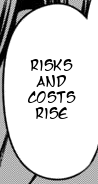

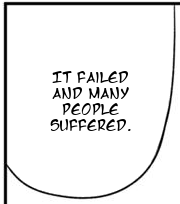

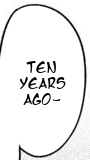

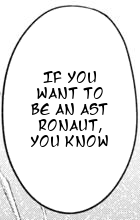

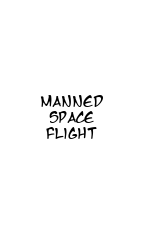

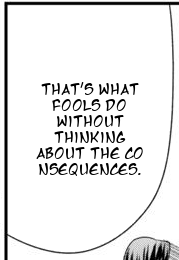

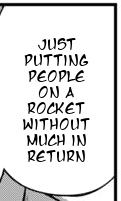

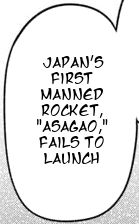

In [44]:
from IPython.display import display
import cv2
import os

manga_font_path = os.path.normpath(os.path.join("../fonts", "mangat.ttf"))

for i, image_path in enumerate(os.listdir(bounding_box_images_path)):
	image_path = os.path.join(bounding_box_images_path, image_path)
	image = cv2.imread(image_path)
	image, contour = process_contour(image)
	text = text_list[i]
	image = add_text(image, text, manga_font_path, contour)
	display(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))


## All in one

This section will contain the code for the entire manga translator pipeline. This pipeline will take a manga image as input and output the translated text from the speech bubbles in the manga image and place the translated text back in the manga image.


image 1/1 c:\Users\denis\Desktop\projects\data-science\manga-translator\model_creation\011.png: 640x480 8 text_bubbles, 350.3ms
Speed: 3.0ms preprocess, 350.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


2024-06-02 01:47:05.750 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base


Object: text_bubble
Coordinates: [608, 88, 748, 308]
Probability: 0.9075
Object: text_bubble
Coordinates: [70, 390, 250, 594]
Probability: 0.9057
Object: text_bubble
Coordinates: [86, 121, 225, 345]
Probability: 0.8989
Object: text_bubble
Coordinates: [683, 672, 827, 906]
Probability: 0.897
Object: text_bubble
Coordinates: [325, 657, 504, 917]
Probability: 0.8882
Object: text_bubble
Coordinates: [639, 389, 760, 590]
Probability: 0.8774
Object: text_bubble
Coordinates: [544, 415, 642, 599]
Probability: 0.8636
Object: text_bubble
Coordinates: [203, 94, 293, 254]
Probability: 0.8618


2024-06-02 01:47:08.414 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-06-02 01:47:09.361 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready
2024-06-02 01:47:10.338 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base


Original text: 宇宙機行士目指してるなら知ってんだろ
Translated text: If you're aiming to be a space pilot, you know that.


2024-06-02 01:47:12.768 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-06-02 01:47:13.664 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready
2024-06-02 01:47:14.573 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base


Original text: 失敗して色んな人が苦しんだんだ
Translated text: It failed and many people suffered.


2024-06-02 01:47:16.941 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-06-02 01:47:17.864 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready
2024-06-02 01:47:18.885 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base


Original text: 日本初の友人ロケット「あるがおの打ち上げ失敗
Translated text: Japan's first rocket launch failure


2024-06-02 01:47:21.506 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-06-02 01:47:22.437 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready
2024-06-02 01:47:23.244 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base


Original text: 有人宇宙飛行なんて
Translated text: Manned space flight


2024-06-02 01:47:25.635 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-06-02 01:47:26.547 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready
2024-06-02 01:47:27.510 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base


Original text: 後先考えないバカのすることだ
Translated text: That's what fools do without thinking about the consequences.


2024-06-02 01:47:29.854 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-06-02 01:47:30.728 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready
2024-06-02 01:47:31.757 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base


Original text: 大した見返りもないのにロケットに人を載せただけで
Translated text: Just putting people on a rocket without much in return


2024-06-02 01:47:34.295 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-06-02 01:47:35.170 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready
2024-06-02 01:47:36.030 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base


Original text: リスクもコストも読ね上がる
Translated text: Risks and costs rise


2024-06-02 01:47:38.438 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-06-02 01:47:39.310 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


Original text: 学年前ーー
Translated text: Before school


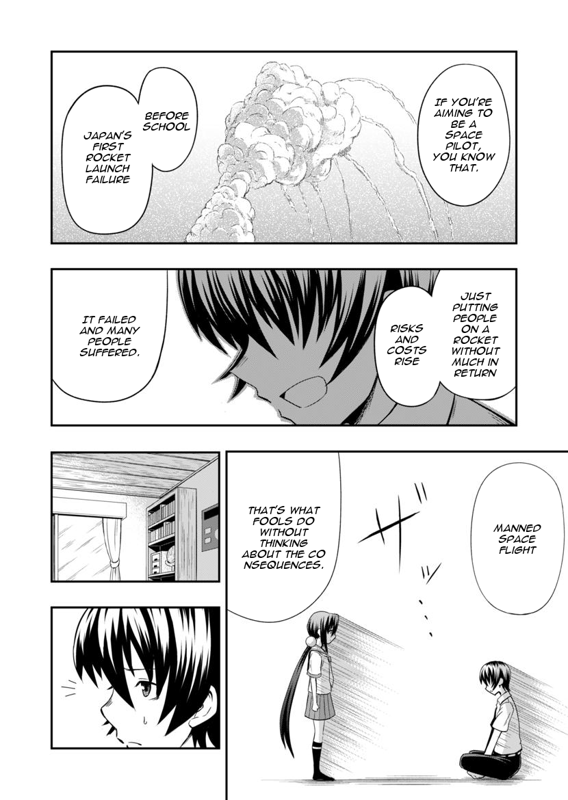

In [2]:
import os
import sys
sys.path.append(os.path.abspath(".."))

from PIL import Image
from ultralytics import YOLO
import numpy as np

# Load the object detection model
from utils.predict_bounding_boxes import predict_bounding_boxes
from utils.translate_manga import translate_manga
from utils.manga_ocr import get_text_from_image
from utils.process_contour import process_contour
from utils.write_text_on_image import add_text

image_path = "./011.png"
image = Image.open(image_path)

# Load the object detection model
best_model_path = "./runs/detect/train5"
object_detection_model = YOLO(os.path.join(best_model_path, "weights/best.pt"))

# Predict bounding boxes
results = predict_bounding_boxes(object_detection_model, image_path)
image = np.array(image)

for result in results:
        x1, y1, x2, y2, score, class_id = result
        detected_image = image[int(y1):int(y2), int(x1):int(x2)]
        im = Image.fromarray(np.uint8((detected_image)*255))
        text = get_text_from_image(im)
        detected_image, cont = process_contour(detected_image)
        text_translated = translate_manga(text)
        image_with_text = add_text(detected_image, text_translated, cont)

# Display the translated image
result_image = Image.fromarray(image, 'RGB')
result_image.save('translated_image.png')

# Display the translated image
result_image = Image.open('translated_image.png')
result_image.thumbnail((800, 800))
display(result_image)